# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from torchvision import models
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import os

import mlflow
from lightning.pytorch.loggers import MLFlowLogger

import matplotlib.pyplot as plt


torch.set_float32_matmul_precision('medium')


/home/sanjeet/ai_workspace/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
BASE_PATH = "" #Add dataset path here
BEST_CHECKPOINT_PATH = "" #Add best checkpoint path here

# Data Module
This handles loading, pairing, and batching dark/bright images.

## Custom Dataset

In [ ]:
class LoLDataset(Dataset):
    def __init__(self, dark_dir, bright_dir, transform):
        self.dark_dir = dark_dir
        self.bright_dir = bright_dir
        self.transform = transform
        
        # Read and sort both folders independently
        self.dark_images = sorted([f for f in os.listdir(dark_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.bright_images = sorted([f for f in os.listdir(bright_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        # Quick safety print if there's a mismatch in folder sizes
        if len(self.dark_images) != len(self.bright_images):
            print(f"WARNING: Found {len(self.dark_images)} dark but {len(self.bright_images)} bright in {dark_dir.split('/')[-2]}")

    def __len__(self): 
        # Safely return the smaller count so it never asks for an index that doesn't exist
        return min(len(self.dark_images), len(self.bright_images))

    def __getitem__(self, idx):
        # Uses the specific filename found in each respective folder
        dark_path = os.path.join(self.dark_dir, self.dark_images[idx])
        bright_path = os.path.join(self.bright_dir, self.bright_images[idx])
        
        dark_img = Image.open(dark_path).convert("RGB")
        bright_img = Image.open(bright_path).convert("RGB")
        
        return self.transform(dark_img), self.transform(bright_img)

## Lightning DataModule

In [ ]:
class LoLDataModule(pl.LightningDataModule):
    def __init__(self, base_path, batch_size=8):
        super().__init__()
        # Pointing to the specific subfolders from your image
        self.train_low = os.path.join(base_path, "Real_captured/Train/Low")
        self.train_high = os.path.join(base_path, "Real_captured/Train/Normal")
        self.val_low = os.path.join(base_path, "Real_captured/Test/Low")
        self.val_high = os.path.join(base_path, "Real_captured/Test/Normal")
        
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def setup(self, stage=None):
        # Training set 
        self.train_ds = LoLDataset(self.train_low, self.train_high, self.transform)
        # Validation set
        self.val_ds = LoLDataset(self.val_low, self.val_high, self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

In [ ]:
# --- TEST ---
def test_datamodule():
    print("Testing DataModule...")
    dm = LoLDataModule(base_path=BASE_PATH) 
    dm.setup()
    
    # Check Training Set
    train_loader = dm.train_dataloader()
    dark_batch, bright_batch = next(iter(train_loader))
    
    print(f"Total training pairs found: {len(dm.train_ds)}")
    print(f"Total validation pairs found: {len(dm.val_ds)}")
    print(f"Batch Shape (Dark): {dark_batch.shape}")
    print(f"Batch Shape (Bright): {bright_batch.shape}")
    
    # Check if pixels are normalized (should be between 0 and 1)
    print(f"Pixel Range: {dark_batch.min():.2f} to {dark_batch.max():.2f}")
    print("DataModule is ready to feed the model.\n")

test_datamodule()

Testing DataModule...
Total training pairs found: 689
Total validation pairs found: 100
Batch Shape (Dark): torch.Size([8, 3, 224, 224])
Batch Shape (Bright): torch.Size([8, 3, 224, 224])
Pixel Range: 0.00 to 0.59
DataModule is ready to feed the model.



# Architecture

In [ ]:
class NanoLILY(nn.Module):
    def __init__(self):
        super(NanoLILY, self).__init__()

        # --- BRANCH A: THE ARTIST ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.dec1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.final_spatial = nn.Conv2d(32, 3, kernel_size=3, padding=1)

        # --- BRANCH B: THE SIEVE ---
        # Initialize with SMALL values (0.01) so it doesn't overwhelm the image early on
        self.freq_mask = nn.Parameter(torch.full((1, 3, 224, 113), 0.01))

        # --- THE FUSION ---
        self.fusion = nn.Sequential(
            nn.Conv2d(6, 3, kernel_size=1),
            nn.Tanh() # Constrains the residual to a stable range [-1, 1]
        )

    def forward(self, x):
        identity = x
        
        # Spatial Pass
        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        up1 = self.dec1(s2)
        spatial_out = self.final_spatial(up1 + s1) 

        # Frequency Pass
        x_fft = torch.fft.rfft2(x)
        x_fft_filtered = x_fft * self.freq_mask
        freq_out = torch.fft.irfft2(x_fft_filtered, s=(224, 224))

        # Fusion
        combined = torch.cat([spatial_out, freq_out], dim=1)
        residual = self.fusion(combined)

        return identity + residual

In [ ]:
# --- TEST ---
model = NanoLILY()
sample_input = torch.randn(1, 3, 224, 224)
output = model(sample_input)
print(f"Success! Output Shape: {output.shape}")

Success! Output Shape: torch.Size([1, 3, 224, 224])


# The Perceptual Loss

In [ ]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # We only need the feature extraction layers
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        # Slicing up to layer 18 (ReLU 4_2)
        self.slice = nn.Sequential(*list(vgg.children())[:18]).eval()
        # Freezing parameters so we don't train VGG
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        output_feat = self.slice(output)
        target_feat = self.slice(target)
        return F.mse_loss(output_feat, target_feat)

In [8]:
# --- TEST ---
def test_vgg_loss():
    print("Testing VGG Loss...")
    criterion = VGGPerceptualLoss()
    
    # Create two slightly different fake images
    img1 = torch.randn(1, 3, 224, 224)
    img2 = img1 + 0.1 # Just a slight difference
    
    loss = criterion(img1, img2)
    print(f"VGG Loss Output: {loss.item():.4f}")
    print("VGG Loss is working correctly.\n")

test_vgg_loss()

Testing VGG Loss...
VGG Loss Output: 0.0034
VGG Loss is working correctly.



# The Training System

In [ ]:
class NanoLILYSystem(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
        # Losses
        self.pixel_loss = nn.L1Loss()
        self.vgg_loss = VGGPerceptualLoss()
        
        # Metrics (higher is better for both)
        self.psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        dark, bright = batch
        output = self.model(dark)

        # 1. Base Losses
        l_pixel = self.pixel_loss(output, bright)
        l_vgg = self.vgg_loss(output, bright)
        
        # FFT (The stable anchor)
        out_fft = torch.fft.rfft2(output.float(), norm="ortho") 
        tar_fft = torch.fft.rfft2(bright.float(), norm="ortho")
        l_fft = F.l1_loss(torch.abs(out_fft), torch.abs(tar_fft))

        # SSIM Loss
        ssim_val = self.ssim(output, bright)
        l_ssim = 1.0 - ssim_val 
        
            
        total_loss = (1.0 * l_pixel) + (0.2* l_ssim) + (0.05 * l_vgg) + (0.05 * l_fft)

        # 2. Metrics & Logging
        psnr_val = self.psnr(output, bright)
        
        self.log_dict({
            "train_loss": total_loss,
            "train_psnr": psnr_val,
            "train_ssim_score": ssim_val,
            "train_l_pixel": l_pixel,
            "ssim_weight": 0.2,
            "epoch": self.current_epoch
        }, prog_bar=True, on_step=False, on_epoch=True)
        
        return total_loss

    def validation_step(self, batch, batch_idx):
        dark, bright = batch
        output = self.model(dark)
        
        # 1. Calculate Full Multi-Part Validation Loss (to match training)
        l_pixel = self.pixel_loss(output, bright)
        l_vgg = self.vgg_loss(output, bright)
        
        # FFT (Stable ortho norm)
        out_fft = torch.fft.rfft2(output.float(), norm="ortho") 
        tar_fft = torch.fft.rfft2(bright.float(), norm="ortho")
        l_fft = F.l1_loss(torch.abs(out_fft), torch.abs(tar_fft))

        ssim_val = self.ssim(output, bright)
        l_ssim = 1.0 - ssim_val 

        val_loss = l_pixel + (0.2 * l_ssim) + (0.05 * l_vgg) + (0.05 * l_fft)


        # 3. Logging
        self.log_dict({
            "val_loss": val_loss,
            "val_l_pixel": l_pixel,
            "val_psnr": self.psnr(output, bright),
            "val_ssim": ssim_val
            }, prog_bar=True, on_epoch=True)
        
        return val_loss

    def configure_optimizers(self):
            optimizer = torch.optim.AdamW(self.parameters(), lr=1e-5, weight_decay=1e-2)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=5 
            )
            
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val_loss",
                    "frequency": 1
                }
            }

In [ ]:
# --- TEST ---
def test_system():
    print("Testing System Integration...")
    model = NanoLILY()
    system = NanoLILYSystem(model)
    
    # Mock a batch of data
    dark = torch.randn(2, 3, 224, 224)
    bright = torch.randn(2, 3, 224, 224)
    batch = (dark, bright)
    
    # Run one training step
    loss = system.training_step(batch, 0)
    print(f"Step Loss: {loss:.4f}")
    print("System Integration is successful.\n")

test_system()

Testing System Integration...


Step Loss: 1.6215
System Integration is successful.



/home/sanjeet/ai_workspace/.venv/lib/python3.12/site-packages/pytorch_lightning/core/module.py:451: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


# Setup MLflow Logger

In [ ]:
mlf_logger = pl.loggers.MLFlowLogger(
    experiment_name="Low Light Image Enhancement",
    run_name = "Fine tuning NanoLILY",
    tracking_uri="http://127.0.0.1:5000"
)


# Training

In [ ]:

# 1. LOAD THE PRE-TRAINED BRAIN (Transfer Learning)
# This extracts the weights from NanoLILY Baseline and puts them in a fresh system
model = NanoLILY()
system = NanoLILYSystem.load_from_checkpoint(
    checkpoint_path=BEST_CHECKPOINT_PATH,
    model=model,
    strict=False # Good practice for fine-tuning
)

# 2. CREATE THE DATAMODULE
dm = LoLDataModule(
    base_path=BASE_PATH, 
    batch_size=32  
)

# Prepare Hyperparameters for logging 
hparams_to_log = {
    "model_name": "NightVisionNet_v2.1_FineTuned",
    "architecture": "Hybrid (CNN-Artist + FFT-Sieve)",
    "loss_components": "L1 + VGG19_Perceptual + FFT_L1 + SSIM (Immediate 0.2)",
    "dataset": "LoL v2 Synthetic",
    "learning_rate": 1e-5, # Updated for fine-tuning
    "optimizer": "AdamW",
    "data_batch_size": dm.batch_size,
    "device": "RTX 3050"
}

checkpoint_callback = ModelCheckpoint(
    monitor="val_ssim",
    mode="max",
    save_top_k=1,
    dirpath="mlruns/checkpoints",
    filename="best-finetune-{epoch:02d}-{val_ssim:.7f}"
)

early_stop_callback = EarlyStopping(
    monitor="val_ssim",
    min_delta=0.00001,
    patience=10, 
    mode="max"
)

# 4. SETUP THE TRAINER FOR FINE-TUNING
trainer = pl.Trainer(
    max_epochs=100,                 
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    logger=mlf_logger,             
    gradient_clip_val=0.5,
    callbacks=[checkpoint_callback, early_stop_callback],
    enable_checkpointing=True,
    num_sanity_val_steps=0         
)

# Log the params manually if MLFlow is active
if mlf_logger.experiment:
    mlf_logger.log_hyperparams(hparams_to_log)

# 5. EXECUTE TRANSFER LEARNING
print("Starting Fine-Tuning Curriculum on LoL v2...")
trainer.fit(system, dm)

print(f"Fine-Tuning Complete! Best checkpoint saved at: {checkpoint_callback.best_model_path}")

/home/sanjeet/ai_workspace/.venv/lib/python3.12/site-packages/lightning_fabric/utilities/cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Using 16bit Automatic Mixed Precision (

🚀 Starting Fine-Tuning Curriculum on LoL v2...


/home/sanjeet/ai_workspace/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/sanjeet/ai_workspace/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:534: Found 19 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 16: 100%|██████████| 22/22 [00:10<00:00,  2.14it/s, v_num=d2fc, val_loss=0.168, val_l_pixel=0.0949, val_psnr=18.60, val_ssim=0.797, train_loss=0.251, train_psnr=17.10, train_ssim_score=0.664, train_l_pixel=0.111, ssim_weight=0.200, epoch=16.00] 
🏃 View run Fine-Tuning LoL v2 Synthetic at: http://127.0.0.1:5000/#/experiments/4/runs/d9c87cf284214b858276e059396bd2fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4
✅ Fine-Tuning Complete! Best checkpoint saved at: /home/sanjeet/ai_workspace/Image Enhancement/mlruns/checkpoints/best-finetune-epoch=06-val_ssim=0.7984134.ckpt


# Quick Visualization

In [ ]:
def evaluate_and_save(system, dm, save_path="evaluation.png"):
    # 1. Force the model to the best available device (GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    system.to(device)
    system.eval()
    
    # 2. Get a batch
    val_loader = dm.val_dataloader()
    batch = next(iter(val_loader))
    dark_batch, bright_batch = batch
    
    # 3. Move specific image to the same device
    dark_img = dark_batch[0:1].to(device)
    
    # 4. Inference
    with torch.no_grad():
        output = system.model(dark_img) 
    
    # 5. Move back to CPU for visualization
    input_np = dark_img.squeeze().cpu().permute(1, 2, 0).numpy()
    output_np = output.squeeze().cpu().permute(1, 2, 0).numpy()
    target_np = bright_batch[0].cpu().permute(1, 2, 0).numpy()
    
    # Clip for safety
    input_np = input_np.clip(0, 1)
    output_np = output_np.clip(0, 1)
    target_np = target_np.clip(0, 1)

    # 6. Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_np)
    axes[0].set_title("Input (Dark)")
    axes[1].imshow(output_np)
    axes[1].set_title("Model Output")
    axes[2].imshow(target_np)
    axes[2].set_title("Ground Truth")
    
    for ax in axes: ax.axis("off")
    plt.show()

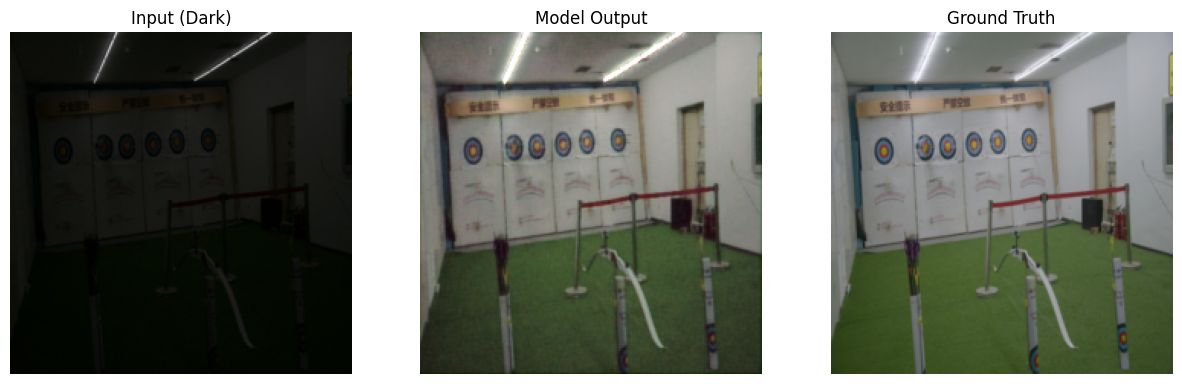

In [15]:
evaluate_and_save(system, dm)